In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression/train.csv
/kaggle/input/house-prices-advanced-regression/test.csv


Load data and combine input data into one DataFrame. Preprocessing from apapiu: https://www.kaggle.com/apapiu/regularized-linear-models

In [50]:
train = pd.read_csv("../input/house-prices-advanced-regression/train.csv")
test = pd.read_csv("../input/house-prices-advanced-regression/test.csv")

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

In [51]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

all_data = pd.get_dummies(all_data)

#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

Below follows problem 2.2. Output submitted to Kaggle. Results for alpha = 0.1 is rmse = 0.13565

2.  Follow the data preprocessing steps from https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models.  Then run a ridge regression usingα= 0.1.Make a submission of this prediction, what is the RMSE you get?(Hint:  remember to exponentiate np.expm1(ypred) your predictions).

In [52]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y)

out = pd.DataFrame({"SalePrice":np.expm1(ridge.predict(X_test))})
i = pd.DataFrame({"Id":test["Id"]})
out = pd.concat([i, out], axis=1)
out.to_csv("Ridge0a1.csv", index=False)

Below follows problem 2.3. CV tuned Ridge and Lasso.

Lasso score: 0.12455

3.  Compare a ridge regression and a lasso regression model.  Optimize the alphas using crossvalidation.  What is the best score you can get from a single ridge regression model and froma single lasso model?

In [53]:
model_ridge = RidgeCV(alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]).fit(X_train, y)
print("Ridge rmse mean: ", rmse_cv(model_ridge).mean())
print("Optimal Ridge Alpha: ", model_ridge.alpha_)

model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
print("Lasso rmse mean: ", rmse_cv(model_lasso).mean())
print("Optimal Lasso Alpha: ", model_lasso.alpha_)

Ridge rmse mean:  0.12775910042397043
Optimal Ridge Alpha:  10.0
Lasso rmse mean:  0.12256735885048142
Optimal Lasso Alpha:  0.0005


Below follows problem 2.4. Lasso coefficients with varying Alpha.

4.  Plot the l0 norm (number of nonzeros) of the coefficients that lasso produces as you vary thestrength of regularization parameter alpha.

    alpha  l0_norm
0  1.0000        3
1  0.5000        3
2  0.2500        4
3  0.1000        8
4  0.0050       30
5  0.0010       79
6  0.0005      110


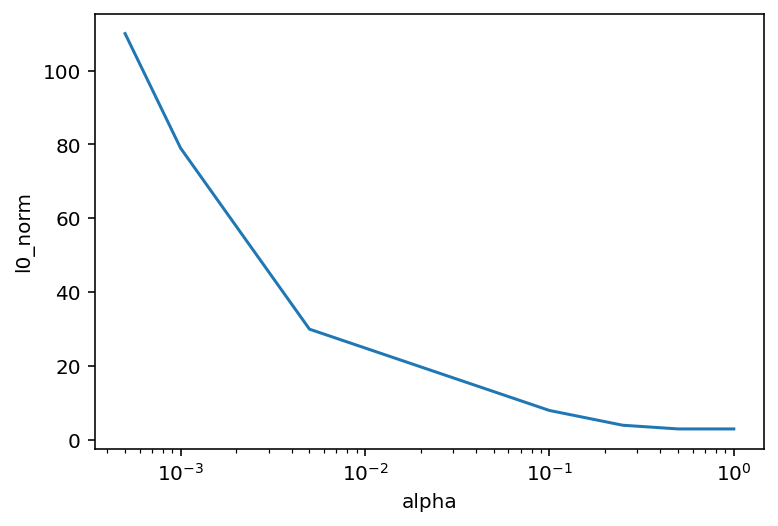

In [54]:
alphas = [1, 0.5, 0.25, 0.1, 0.005, 0.001, 0.0005]
coef_alpha = [0, 0, 0, 0, 0, 0, 0]
for i in range(0,7):
    model_las = Lasso(alpha = alphas[i]).fit(X_train, y)
    coef = pd.Series(model_las.coef_, index = X_train.columns)
    coef_alpha[i] = sum(coef != 0)
    
df = pd.DataFrame({"alpha":alphas, "l0_norm":coef_alpha})

print(df)

plt.plot('alpha', 'l0_norm', data = df)
plt.xlabel('alpha')
plt.ylabel('l0_norm')
plt.xscale('log')
plt.show()

5.  Add the outputs of your models as features and train a ridge regression on all the featuresplus the model outputs.  Be careful not to overfit.  What score can you get?

Score: 0.12495

In [55]:
ridge_y = model_ridge.predict(X_train)
lasso_y = model_lasso.predict(X_train)
new_y = pd.DataFrame({"ridge":ridge_y, "lasso":lasso_y})

X_train = pd.concat([X_train, new_y], axis=1)

model_ridge2 = RidgeCV(alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]).fit(X_train, y)
print("Ridge rmse mean: ", rmse_cv(model_ridge2).mean())
print("Optimal Ridge Alpha: ", model_ridge2.alpha_)

ridge_y = model_ridge.predict(X_test)
lasso_y = model_lasso.predict(X_test)
new_y = pd.DataFrame({"ridge":ridge_y, "lasso":lasso_y})

X_test = pd.concat([X_test, new_y], axis=1)

out = pd.DataFrame({"SalePrice":np.expm1(model_ridge2.predict(X_test))})
i = pd.DataFrame({"Id":test["Id"]})
out = pd.concat([i, out], axis=1)
out.to_csv("BootstrapRidge.csv", index=False)

Ridge rmse mean:  0.12407650970641473
Optimal Ridge Alpha:  10.0
